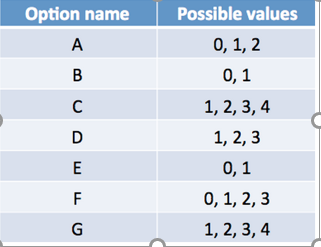

In [1]:
from PIL import Image
Image.open('policies.png')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.linear_model.logistic import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
# evaluation
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score as f1
from sklearn.metrics import log_loss

#feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier

D:\JUPYTER\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\JUPYTER\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
df = pd.read_csv('train.csv')
df2=pd.read_csv('test.csv')
pd.set_option('display.max_columns', None)
df.shape,df2.shape

((665249, 25), (198856, 25))

## Step1.Data Description and Preprocessing

### 1.1 Combine options as plan

In [5]:
df['plan'] = df['A'].astype(str)+df['B'].astype(str)+df['C'].astype(str)+df['D'].astype(str)+\
df['E'].astype(str)+df['F'].astype(str)+df['G'].astype(str)
df['plan'] = df['plan'].astype(int)

In [6]:
df2['plan'] = df2['A'].astype(str)+df2['B'].astype(str)+df2['C'].astype(str)+df2['D'].astype(str)+\
df2['E'].astype(str)+df2['F'].astype(str)+df2['G'].astype(str)
df2['plan'] = df2['plan'].astype(int)

### 1.2 Policies and Plans distribution

In [7]:
pur = df[df['record_type']==1]

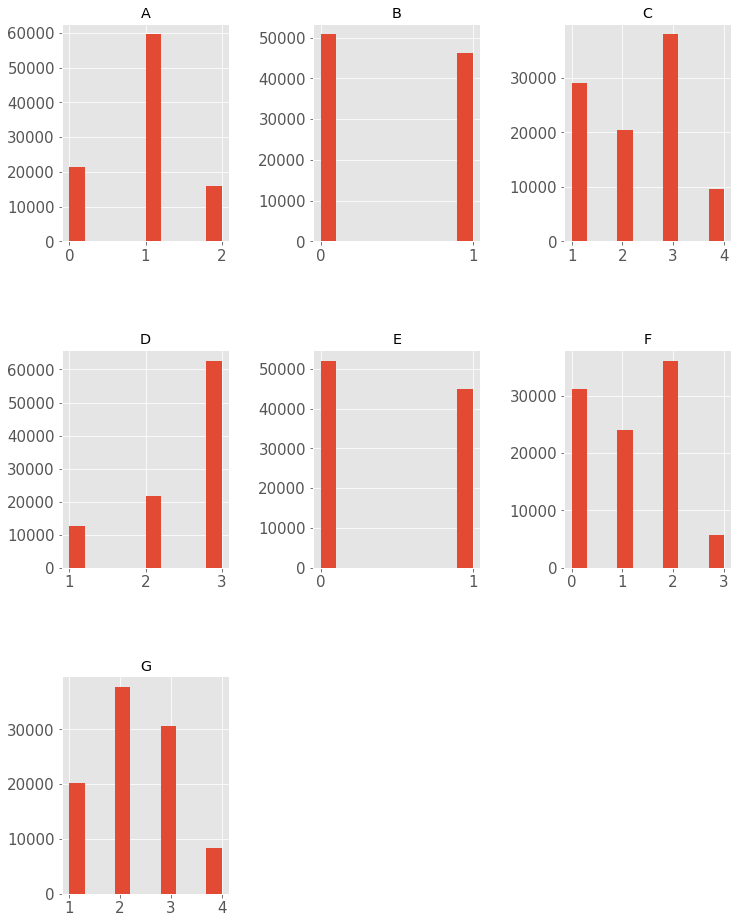

In [8]:
# policies didtribution
plt.style.use('ggplot')
policies = ['A','B','C','D','E','F','G']
fig = plt.figure(figsize=(12,16))
for c,num in zip(policies, range(1,8)):
    ax = fig.add_subplot(3,3,num)
    pur.hist(column=c,ax=ax)
    ax.tick_params(labelsize=15)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig('4.png',dpi=200, bbox_inches='tight')
plt.show()

In [9]:
print('Data have %d kinds of plans' % (3*2*4*3*2*4*4))
print('The possibility of guessing a plan correctly is %f' % (1/(3*2*4*3*2*4*4)))

Data have 2304 kinds of plans
The possibility of guessing a plan correctly is 0.000434


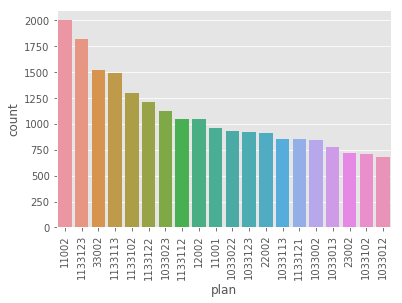

In [10]:
# high frequency plan
def FreqCharts(df,col):
    plan_counts = df[col].value_counts().to_frame()
    plan_counts.columns=['counts']
    plan_counts.sort_values(by='counts', ascending=False, inplace=True)
    freqchart = sns.barplot(x=plan_counts.index[:20],y=plan_counts.counts[:20],order=plan_counts.index[:20])
    for item in freqchart.get_xticklabels():
        item.set_rotation(90)
    freqchart.set(xlabel=col, ylabel='count')
FreqCharts(pur, 'plan')
plt.savefig('3.png',dpi=200, bbox_inches='tight')
plt.show()

### 1.3 Missing Values

In [11]:
for i in df.columns:
    if df[i].count()<len(df):
        print(i,'has missing values:%f' % (len(df[i])-df[i].count()))

car_value has missing values:1531.000000
risk_factor has missing values:240418.000000
C_previous has missing values:18711.000000
duration_previous has missing values:18711.000000


#### risk_factor has too many missing values, we have to delete this factor.  <br>Car_value: How valuable was the customer’s car when new<br> C_previous: What the customer formerly had or currently has for product option C (0=nothing, 1, 2, 3,4)<br>duration_previous:how long (in years) the customer was covered by their previous issuer

In [12]:
df.drop(columns='risk_factor', inplace=True)
df['C_previous'].fillna(0,inplace=True)
df['car_value'].fillna(0,inplace=True)
df['duration_previous'].fillna(0,inplace=True)

In [13]:
for i in df2.columns:
    if df2[i].count()<len(df2):
        print(i,'has missing values:%f' % (len(df2[i])-df2[i].count()))

location has missing values:678.000000
car_value has missing values:739.000000
risk_factor has missing values:75487.000000
C_previous has missing values:9769.000000
duration_previous has missing values:9769.000000


In [14]:
df2.drop(columns='risk_factor', inplace=True)
df2['C_previous'].fillna(0,inplace=True)
df2['car_value'].fillna(0,inplace=True)
df2['duration_previous'].fillna(0,inplace=True)

### Step2. Use naive approach as baseline

In [15]:
ind = df[df['record_type']==1].index

In [16]:
naive = np.array(df.take(ind,axis=0)['plan']) - np.array(df.take(ind-1,axis=0)['plan'])

In [17]:
print('Accuracy of naive approach for training data is:',np.sum(naive==0)/len(naive))

Accuracy of naive approach for training data is: 0.6878949375831108


## Step3. Baseline Obsevation and Customer Classification 
#### As we mentiond in report, baseline has limitation in testing data. And more important, wrongly changing baseline is an expensive cost for prediction accuracy. So, we should only change base line of definitely unstable customers (whose purchae is different with last quote). Therefore a classification for customer is necessary. Fearure engineering and baseline observeation should be down
#### Planfreq: The frequencies of every plan<br>Customer Plan Counts: How many plan shows for a customer during the quotes process<br>Consider Times: Total numbers of records a customer has during the quotes process<br> target: whether customer change his mind after last quotes or not (0: not change, 1:change)

### 3.1 Feature Engineering for traning data

In [18]:
# planfreq
df['planfreq'] = df.groupby(['plan'])['customer_ID'].transform('count')

In [19]:
# Dataset for customers
customer=pd.DataFrame()
customer['customer_ID'] = df[df['record_type']==1]['customer_ID'].values.tolist()

In [20]:
# target for training data
index1 = np.array(df[df['record_type']==1].index) # purchase
index2 = index1-1 # last quote
quote = ['customer_ID','A','B',"C","D","E","F","G","plan"]
pur, lq = df.ix[index1,quote].reset_index(drop=True),df.ix[index2,quote].reset_index(drop=True)
assert pur.shape==lq.shape
diff = pur-lq
diff.columns=['customer_ID','SameA','SameB','SameC','SameD','SameE','SameF','SameG','target']
for i in ['SameA','SameB','SameC','SameD','SameE','SameF','SameG',"target"]:
    customer[i] = diff[i].apply(lambda x:0 if x==0 else 1)

In [21]:
# Customer PlanCounts
customer['PlanCounts'] = df.groupby('customer_ID')['plan'].nunique().tolist()
# Consider Times (not include purchasement row)
ConsiderTimes = list(df[df['record_type']==1]['shopping_pt']-1)
customer['ConsiderTimes'] = ConsiderTimes

In [22]:
# Family 0:no family, 1: with family
def f(row):
    if row['group_size']+row['married_couple']<=1 and row['age_youngest']>=18:
        val=0
    else:
        val=1
    return val
df['family']=df.apply(f, axis=1)
df.drop(columns=['group_size','married_couple'], inplace=True)

In [23]:
# time
customer['time']=df[df['record_type']==1]['time'].apply(lambda x:int(x.split(':')[0])).tolist()
def f(x):
    if x>=6 and x<=18:
        val = 0
    else:
        val = 1
    return val
customer['time']=customer['time'].apply(f)

In [24]:
df.drop(columns = ['time'],inplace=True)
df_all = df.merge(customer, on='customer_ID', how='left')

In [25]:
title=df_all.columns.tolist()
title.remove('target')
title.append('target')
df_all = df_all[title]

In [26]:
df_all.shape

(665249, 35)

In [27]:
df_all.to_csv('ALL.csv',index=False)

### 3.2 Feature Engineering for testing data

In [28]:
# planfreq
df2['planfreq'] = df2.groupby(['plan'])['customer_ID'].transform('count')

In [29]:
# customer data
df2['index']=df2.index
ind=df2.groupby(['customer_ID'])['index'].max().values
df3=df2.take(ind,axis=0)

In [30]:
customer2=pd.DataFrame()

In [31]:
# Customer ID
customer2['customer_ID'] = df3['customer_ID'].values.tolist()

In [32]:
# Customer PlanCounts
customer2['PlanCounts'] = df2.groupby('customer_ID')['plan'].nunique().tolist()

In [33]:
# Consider Times (not include purchasement row)
customer2['ConsiderTimes']=df3['shopping_pt'].values

In [34]:
# Family 0:no family, 1: with family
def f(row):
    if row['group_size']+row['married_couple']<=1 and row['age_youngest']>=18:
        val=0
    else:
        val=1
    return val
df2['family']=df2.apply(f, axis=1)
df2.drop(columns=['group_size','married_couple'], inplace=True)

In [35]:
# time
customer2['time']=df3['time'].apply(lambda x:int(x.split(':')[0])).tolist()
def f(x):
    if x>=6 and x<=18:
        val = 0
    else:
        val = 1
    return val
customer2['time']=customer2['time'].apply(f)

In [36]:
df2.drop(columns = ['index','time'],inplace=True)
df2_all = df2.merge(customer2, on='customer_ID', how='left')

In [37]:
df2_all.to_csv('ALL2.csv',index=False)

## 3.3 Baseline Limitation

In [156]:
pur=df_all[df_all['record_type']==1]

In [38]:
def accuracy(df,colname):
    return len(df[df[colname]==0])/len(df)

def accPlots(df, col, color):
    a = np.min(df[col])
    b = np.max(df[col])+1
    accList = []
    size = []
    for i in range(a,b):
        df_n = df[df[col]==i]
        accList.append(accuracy(df_n,'target'))
        size.append(len(customer2[customer2[col]==i])/40)
    plt.plot([i for i in range(a,b)], accList,c=color)
    plt.scatter([i for i in range(a,b)], accList,s=size,c=color)
    plt.xlabel(col, fontsize=18)
    plt.ylabel('Baseline Accuracy', fontsize=16)

In [157]:
print("Accuarcy of baseline in training set:",accuracy(pur,'target'))

Accuarcy of baseline in training set: 0.6878949375831108


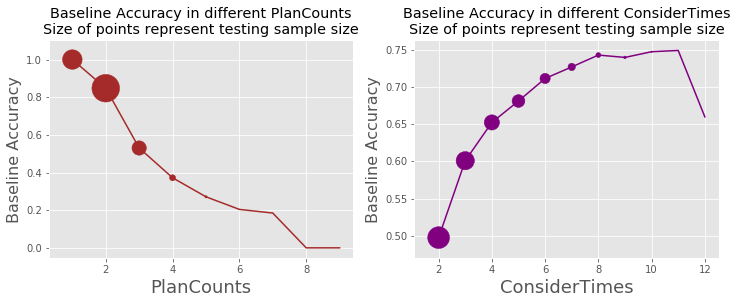

In [39]:
plt.figure(figsize=(12,4))
plt.subplot(121)
accPlots(customer, 'PlanCounts',color='brown')
plt.title('Baseline Accuracy in different PlanCounts\nSize of points represent testing sample size')
plt.subplot(122)
accPlots(customer, 'ConsiderTimes',color='purple')
plt.title('Baseline Accuracy in different ConsiderTimes\nSize of points represent testing sample size')
plt.savefig('2.png',dpi=200, bbox_inches='tight')
plt.show()

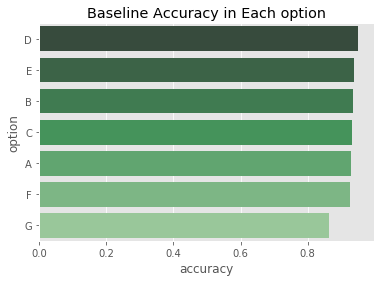

In [40]:
dic=pd.DataFrame()
lst = [accuracy(customer,i) for i in ['SameA','SameB','SameC','SameD','SameE','SameF','SameG']]
dic['option'],dic['accuracy']=['A','B','C','D','E','F','G'],lst
dic.sort_values(by='accuracy',ascending=False,inplace=True)
pal = sns.color_palette("Greens_d", len(dic))
g=sns.barplot(x='accuracy',y='option',data=dic, palette=np.array(pal))
plt.title('Baseline Accuracy in Each option')
plt.savefig('1.png',dpi=200, bbox_inches='tight')
plt.show()

## Step 4 Special Rules hidden in dataset

### 4.1 Purchase Preference in States

In [41]:
option=['A','B','C','D', 'E','F','G']
print('Dataset have',len(df['state'].value_counts()), 'states')

Dataset have 36 states


In [42]:
index1 = np.array(df[df['record_type']==1].index) # purchasement
index2 = index1-1 # last quote
pur,lq=df.iloc[index1,:],df.iloc[index2,:]
df1 = pd.DataFrame(pur.groupby('state')['A','B','C','D', 'E','F','G'].nunique())

In [43]:
df1.head()

,A,B,C,D,E,F,G
state,,,,,,,
AL,3,2,4,3,2,4,4
AR,3,2,4,3,2,4,4
CO,3,2,4,3,2,4,4
CT,3,2,4,3,2,4,4
DC,3,2,4,3,2,4,4


In [44]:
df2 = pd.DataFrame(lq.groupby('state')['A','B','C','D', 'E','F','G'].nunique())

In [45]:
state_diff = (df1-df2)
for i in option:
    if len(state_diff[i].unique())==1:
        print(i, ': no purchasement prefence in this option')
    else:
        print(i, ': purchasement prefence in this option')
state_diff.drop(columns=['A','B','E','F'],inplace=True)
state_diff['sum']=state_diff['C']+state_diff['D']+state_diff['G']
state_diff[state_diff['sum']!=0]

A : no purchasement prefence in this option
B : no purchasement prefence in this option
C : purchasement prefence in this option
D : purchasement prefence in this option
E : no purchasement prefence in this option
F : no purchasement prefence in this option
G : purchasement prefence in this option


,C,D,G,sum
state,,,,
FL,0,0,-1,-1
GA,-1,-1,0,-2


In [46]:
def show(state,opt):
    print('Preference for option '+opt+' in'+state)
    print('purachasement:')
    print(pur[pur['state']==state][opt].value_counts())
    print('\n')
    print('lastquote:')
    print(lq[lq['state']==state][opt].value_counts())

In [47]:
show('GA','C')

Preference for option C inGA
purachasement:
2    775
3    407
4     88
Name: C, dtype: int64


lastquote:
2    730
3    421
4     96
1     23
Name: C, dtype: int64


In [48]:
show('GA',"D")

Preference for option D inGA
purachasement:
2    755
3    515
Name: D, dtype: int64


lastquote:
2    766
3    483
1     21
Name: D, dtype: int64


In [49]:
show('FL','G')

Preference for option G inFL
purachasement:
3    11696
4     2909
Name: G, dtype: int64


lastquote:
3    12050
4     2391
2      164
Name: G, dtype: int64


## 4.2 Association Rules(SPSS)

In [50]:
assRules=pd.DataFrame()
for i in policies:
    newname = "#"+i
    assRules[newname] = df[df['record_type']==1][i].apply(lambda x:str(x)+i)

In [51]:
assRules.head()

,#A,#B,#C,#D,#E,#F,#G
8,1A,0B,2C,2D,1E,2F,1G
14,0A,0B,3C,2D,0E,0F,2G
22,0A,0B,1C,2D,0E,0F,1G
26,1A,1B,3C,2D,1E,1F,3G
32,1A,1B,1C,1D,0E,2F,2G


In [ ]:
# assRules.to_csv('AssociationRule.csv')

Result of SPSS Association Rules:




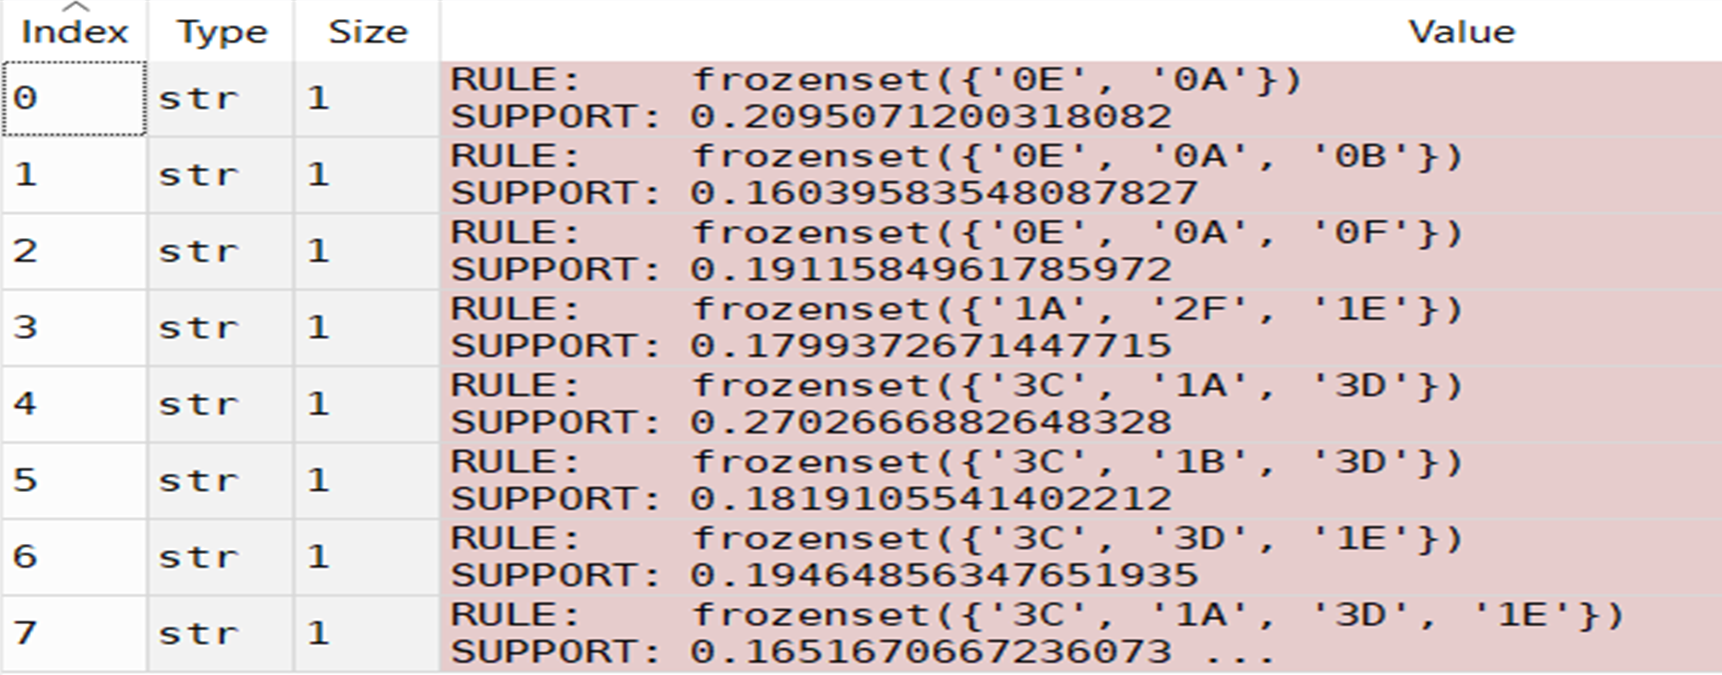

In [5]:
print('Result of SPSS Association Rules:\n\n')
Image.open('AssRules.png')

# Machine Learning

## Step 5 Machine Learning for customer classification

### 5.1 Split Traing Data(70%,30%)

In [ ]:
df_all=pd.read_csv('all.csv')
df2_all=pd.read_csv('all2.csv')

In [52]:
purchase = df_all[df_all['record_type']==1].reset_index(drop=True)
dropCol = ['customer_ID','record_type','shopping_pt','state','location','A','B','C','D', 'E','F','car_value',\
           'cost','SameA','SameB','SameC','SameD','SameE','SameF','SameG','planfreq','plan']
cusID = purchase['customer_ID'].values.tolist()
purchase.drop(columns=dropCol,inplace=True)

In [53]:
## dataset for customer classification
predictC=purchase.drop(columns=['G'])
## dataset for g prediction
predictG=purchase.drop(columns=['target'])

In [54]:
# predictC.to_csv('predictC.csv',index=False)
# predictG.to_csv('predictG.csv',index=False)

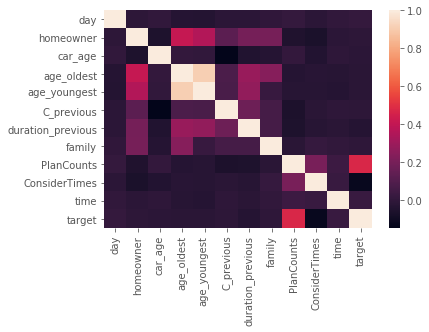

In [55]:
sns.heatmap(data=predictC.corr())

In [56]:
scaler=StandardScaler()
log_reg = LogisticRegression()
log_reg2 = LogisticRegression(random_state=0, class_weight='balanced')
svm = SVC()
knn = KNeighborsClassifier()
xgc=XGBClassifier()

In [57]:
predictC['target'].value_counts()

0    66732
1    30277
Name: target, dtype: int64

In [58]:
X_train,X_test, y_train, y_test=train_test_split(predictC.drop(columns='target'),predictC['target'],\
                                                 test_size=0.3, random_state=0)

In [59]:
testID = [cusID[int(i)] for i in X_test.index]

### 5.2 Feature Selection

In [60]:
# linear svc
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
model = SelectFromModel(lsvc, prefit=True)
lsvc_train = pd.DataFrame(model.transform(X_train))
lsvc_test = pd.DataFrame(model.transform(X_test))
lsvc_train.shape

(67906, 9)

In [61]:
# ExtraTreesClassifier
etc = ExtraTreesClassifier()
etc = etc.fit(X_train, y_train)
model = SelectFromModel(etc, prefit=True)
etc_train = pd.DataFrame(model.transform(X_train))
etc_test  = pd.DataFrame(model.transform(X_test))
etc_train.shape

(67906, 5)

### 5.3 Evaluation

In [62]:
def predict(model,Xtrain,Xtest,ytrain=y_train,ytest=y_test):
    global prob_2, predict_2
    scaler.fit(Xtrain)
    Xtrain = scaler.transform(Xtrain)
    Xtest =scaler.transform(Xtest)
    model.fit(Xtrain,ytrain)
    prob_1 = model.predict_proba(Xtrain)
    predict_1 = model.predict(Xtrain)
    prob_2 = model.predict_proba(Xtest)
    predict_2 = model.predict(Xtest)
    print('Train Resutl:\nLogLoss: %f \nAccuracy: %f\nrecall: %f\nprecision: %f\nf1:%f' % \
          (log_loss(ytrain,prob_1),acc(ytrain, predict_1),recall(ytrain, predict_1),precision(ytrain, predict_1),\
          f1(ytrain, predict_1)))
    print('\nTest Result:\nLogLoss: %f \nAccuracy: %f\nrecall: %f\nprecision: %f\nf1:%f' % \
          (log_loss(ytest,prob_2),acc(ytest, predict_2),recall(ytest, predict_2),precision(ytest, predict_2),\
          f1(ytest, predict_2)))

In [63]:
predict(log_reg,lsvc_train, lsvc_test)

Train Resutl:
LogLoss: 0.464062 
Accuracy: 0.780358
recall: 0.515717
precision: 0.702285
f1:0.594712

Test Result:
LogLoss: 0.462935 
Accuracy: 0.782084
recall: 0.519210
precision: 0.702990
f1:0.597282


In [64]:
predict(log_reg,etc_train, etc_test)

Train Resutl:
LogLoss: 0.499834 
Accuracy: 0.739242
recall: 0.345304
precision: 0.657602
f1:0.452829

Test Result:
LogLoss: 0.498732 
Accuracy: 0.741745
recall: 0.350188
precision: 0.660558
f1:0.457720


In [67]:
predict(log_reg,X_train, X_test)
p1=prob_2

Train Resutl:
LogLoss: 0.464061 
Accuracy: 0.780402
recall: 0.515623
precision: 0.702472
f1:0.594717

Test Result:
LogLoss: 0.462943 
Accuracy: 0.782222
recall: 0.519099
precision: 0.703471
f1:0.597383


In [66]:
predict(xgc,X_train, X_test)
p2=prob_2

D:\JUPYTER\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Train Resutl:
LogLoss: 0.438699 
Accuracy: 0.781831
recall: 0.522598
precision: 0.702992
f1:0.599519

Test Result:
LogLoss: 0.437817 
Accuracy: 0.784386
recall: 0.524067
precision: 0.707346
f1:0.602067


D:\JUPYTER\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 5.4 improve precision

#### 5.4.1 Improvement for logistic regression

In [68]:
def improve(prob, standard,customer_id=testID,y_test=y_test.values):
    log = pd.DataFrame()
    log['id'] = customer_id
    log['proba'] = prob[:,1]
    log['pred'] = log['proba'].apply(lambda x:1 if x>=standard else 0)
    log['label'] = y_test
    return log

In [69]:
result=pd.DataFrame()
lst1,lst2,lst3 =[],[],[]
i=0.5
while i<1:
    lst1.append(round(i,2))
    log=improve(p1,i)
    lst2.append(precision(log['label'], log['pred']))
    lst3.append(len(log[log['pred']==1]))
    i+=0.05

In [70]:
result['threshold'],result['precision'],result['Unstable Sample Size']=lst1,lst2,lst3
result

,threshold,precision,Unstable Sample Size
0,0.50,0.703471,6684
1,0.55,0.723036,5943
2,0.60,0.753260,4985
3,0.65,0.775510,4018
4,0.70,0.789184,3273
5,0.75,0.788934,2241
6,0.80,0.806607,1665
7,0.85,0.810329,1123
8,0.90,0.806061,660
9,0.95,0.821168,274


In [71]:
log1,log2,log3,log4,log5=improve(p1,0.5),improve(p1,0.6),improve(p1,0.7),improve(p1,0.8),improve(p1,0.9)

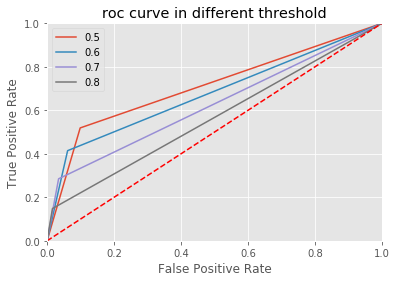

In [72]:
plt.figure(0).clf()
fpr, tpr, threshold = metrics.roc_curve(log1['label'],log1['pred'])
plt.plot(fpr,tpr,label="0.5")
fpr, tpr, threshold = metrics.roc_curve(log2['label'],log2['pred'])
plt.plot(fpr,tpr,label="0.6")
fpr, tpr, threshold = metrics.roc_curve(log3['label'],log3['pred'])
plt.plot(fpr,tpr,label="0.7")
fpr, tpr, threshold = metrics.roc_curve(log4['label'],log4['pred'])
plt.plot(fpr,tpr,label="0.8")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('roc curve in different threshold')
plt.legend(loc=0)
plt.savefig('roc.png',dpi=200, bbox_inches='tight')
plt.show()

#### 5.4.2 improvement for XGboost

In [160]:
result=pd.DataFrame()
lst1,lst2,lst3 =[],[],[]
i=0.5
while i<1:
    lst1.append(round(i,2))
    log=improve(p2,i)
    lst2.append(precision(log['label'], log['pred']))
    lst3.append(len(log[log['pred']==1]))
    i+=0.005

In [159]:
result['threshold'],result['precision'],result['Unstable Sample Size']=lst1,lst2,lst3
result

,threshold,precision,Unstable Sample Size
0,0.50,0.707346,6711
1,0.55,0.731128,5895
2,0.60,0.760507,4973
3,0.65,0.812518,3547
4,0.70,0.837049,3050
5,0.75,0.867112,2393
6,0.80,0.934426,1281
7,0.85,0.959617,941
8,0.90,1.000000,688
9,0.95,1.000000,506


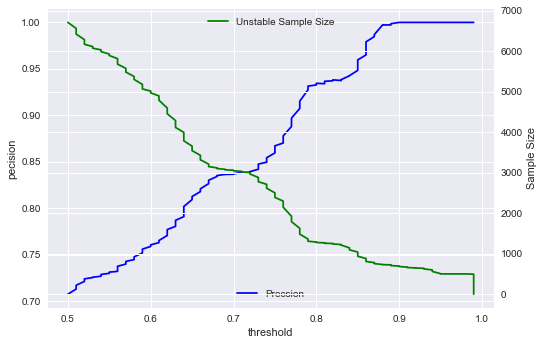

In [173]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(lst1[:-1], lst2[:-1], color="blue", label="Precsion")
ax2.plot(lst1[:-1], lst3[:-1], color="green", label="Unstable Sample Size")
ax1.set_xlabel("threshold")
ax1.set_ylabel("pecision")
ax2.set_ylabel("Sample Size")
ax2.legend(loc=9)
ax1.legend(loc=8)
plt.savefig('threshold.png',dpi=100, bbox_inches='tight')

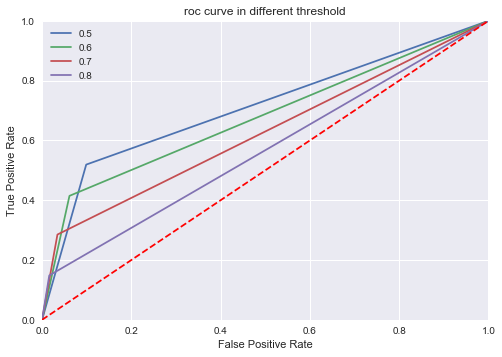

In [75]:
log1,log2,log3,log4,log5=improve(p1,0.5),improve(p1,0.6),improve(p1,0.7),improve(p1,0.8),improve(p1,0.9)
plt.style.use('seaborn')
plt.figure(0).clf()
fpr, tpr, threshold = metrics.roc_curve(log1['label'],log1['pred'])
plt.plot(fpr,tpr,label="0.5")
fpr, tpr, threshold = metrics.roc_curve(log2['label'],log2['pred'])
plt.plot(fpr,tpr,label="0.6")
fpr, tpr, threshold = metrics.roc_curve(log3['label'],log3['pred'])
plt.plot(fpr,tpr,label="0.7")
fpr, tpr, threshold = metrics.roc_curve(log4['label'],log4['pred'])
plt.plot(fpr,tpr,label="0.8")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('roc curve in different threshold')
plt.legend(loc=0)
plt.savefig('roc.png',dpi=200, bbox_inches='tight')
plt.show()

### XGBoost is better than LogiticRegression

## Step 6 Prediction for Individual G

In [76]:
X_train,X_test, y_train, y_test=train_test_split(predictG.drop(columns='G'),predictG['G'],\
                                                 test_size=0.3, random_state=0)

In [77]:
predictG['G'].value_counts()

2    37778
3    30697
1    20257
4     8277
Name: G, dtype: int64

In [78]:
param_grid = {
 'max_depth':[i for i in range(3,10,2)],
 'min_child_weight':[i for i in range(1,6,2)],
 'colsample_bytree':[0.8,0.9,1]
}
xgc=XGBClassifier(
       learning_rate =0.05, n_estimators=500,
       objective= 'multi:softmax',num_class=4, nthread=-1)
grid_search = GridSearchCV(xgc, param_grid)

In [79]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [80]:
grid_search.fit(X_train,y_train)

In [83]:
xgc=XGBClassifier(
       learning_rate =0.05, n_estimators=500,max_depth=9,min_child_weight=1,colsample_bytree=0.8,
       objective= 'multi:softmax',num_class=4, nthread=-1)

In [85]:
xgc.fit(X_train,y_train)

In [86]:
predictedG=xgc.predict(X_test)

In [87]:
print('Accuracy:',acc(predictedG,y_test))

Accuracy: 0.9359541


## Step 7 improve baseline for Unstable Customer

In [88]:
test_all = df_all[df_all['customer_ID'].isin(testID)].reset_index(drop=True)

In [89]:
print('baseline of testing:',accuracy(test_all,'target'))

baseline of testing: 0.7046699373098876


In [90]:
ind = test_all[test_all['record_type']==1].index-1
baseline=test_all.iloc[ind,:][['customer_ID','plan']]

In [91]:
pur=test_all[test_all['record_type']==1]

### 7.1 change baseline with States Preference

In [92]:
fl=pur[(pur['state']=='FL') & (pur['G']==2)]
fl

,customer_ID,shopping_pt,record_type,day,state,location,homeowner,car_age,car_value,age_oldest,age_youngest,C_previous,duration_previous,A,B,C,D,E,F,G,cost,plan,planfreq,family,SameA,SameB,SameC,SameD,SameE,SameF,SameG,PlanCounts,ConsiderTimes,time,target


In [93]:
GA=pur[(pur['state']=='GA') & (pur['C']==1)]
GA

,customer_ID,shopping_pt,record_type,day,state,location,homeowner,car_age,car_value,age_oldest,age_youngest,C_previous,duration_previous,A,B,C,D,E,F,G,cost,plan,planfreq,family,SameA,SameB,SameC,SameD,SameE,SameF,SameG,PlanCounts,ConsiderTimes,time,target


In [94]:
GA=pur[(pur['state']=='GA') & (pur['D']==1)]
GA

,customer_ID,shopping_pt,record_type,day,state,location,homeowner,car_age,car_value,age_oldest,age_youngest,C_previous,duration_previous,A,B,C,D,E,F,G,cost,plan,planfreq,family,SameA,SameB,SameC,SameD,SameE,SameF,SameG,PlanCounts,ConsiderTimes,time,target


### 7.2 Change Baseline with Association Rules

#### this step is finished in excel by the association rules output of SPSS, but result is not excellent
#### the relationship among options is not strong enough to beat baseline

### 7.3 Change Baseline with predicted G

In [95]:
changeID = log5[log5['proba']>=0.80]['id'].values
len(changeID)

1665

In [96]:
baseline['G']=predictedG
baseline['G']=baseline['G'].astype(str)
baseline['plan']=baseline['plan'].astype(str)

In [97]:
for i in changeID:
    baseline.loc[baseline['customer_ID']==i,'plan'] = baseline.loc[baseline['customer_ID']==10129782,'plan'].values[0][:-1]+baseline.loc[baseline['customer_ID']==10129782,'G'].values[0]

In [98]:
baseline['plan']=baseline['plan'].astype(int)

In [99]:
baseline['diff']=np.array(baseline['plan'])-np.array(pur['plan'])

In [101]:
print('beat baseline:',len(baseline[baseline['diff']==0])/len(baseline))

beat baseline: 0.00271


## Step 8 Use real testing data provided by Kaggle

### 8.1 Machine Learning

In [102]:
df_all.shape,df2_all.shape

((665249, 35), (198856, 27))

In [103]:
train = df_all[df_all['record_type']==1]
df2_all['index']=df2_all.index
ind=df2_all.groupby(['customer_ID'])['index'].max().values
test=df2_all.take(ind,axis=0)

In [104]:
dropCol = ['customer_ID','record_type','shopping_pt','state','location','A','B','C','D', 'E','F','car_value',\
           'cost','SameA','SameB','SameC','SameD','SameE','SameF','SameG','plan','planfreq']
train.drop(columns=dropCol,inplace=True)

In [105]:
dropCol = ['customer_ID','record_type','shopping_pt','state','location','A','B','C','D', 'E','F','G','car_value',\
           'cost','plan','planfreq','index']
testID=test['customer_ID'].values.tolist()
baseline=test[['A','B','C','D','E','F','G']].reset_index(drop=True)
test.drop(columns=dropCol,inplace=True)

In [106]:
train.describe()

,day,homeowner,car_age,age_oldest,age_youngest,C_previous,duration_previous,G,family,PlanCounts,ConsiderTimes,time,target
count,97009.000000,97009.000000,97009.000000,97009.000000,97009.000000,97009.000000,97009.000000,97009.000000,97009.000000,97009.000000,97009.000000,97009.000000,97009.000000
mean,2.082683,0.545485,8.181066,45.181622,42.682545,2.432836,6.040254,2.278263,0.255255,2.550485,5.857601,0.019689,0.312105
std,1.468060,0.497929,5.796504,17.389647,17.488953,1.053662,4.712596,0.888322,0.436007,1.050401,1.998357,0.138930,0.463355
min,0.000000,0.000000,0.000000,18.000000,16.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000
25%,1.000000,0.000000,3.000000,29.000000,26.000000,1.000000,2.000000,2.000000,0.000000,2.000000,4.000000,0.000000,0.000000
50%,2.000000,1.000000,8.000000,44.000000,40.000000,3.000000,5.000000,2.000000,0.000000,2.000000,6.000000,0.000000,0.000000
75%,3.000000,1.000000,12.000000,60.000000,57.000000,3.000000,9.000000,3.000000,1.000000,3.000000,7.000000,0.000000,1.000000
max,6.000000,1.000000,85.000000,75.000000,75.000000,4.000000,15.000000,4.000000,1.000000,9.000000,12.000000,1.000000,1.000000


In [107]:
test.describe()

,day,homeowner,car_age,age_oldest,age_youngest,C_previous,duration_previous,family,PlanCounts,ConsiderTimes,time
count,55716.000000,55716.000000,55716.000000,55716.000000,55716.000000,55716.000000,55716.000000,55716.000000,55716.000000,55716.000000,55716.000000
mean,1.912323,0.544081,8.127809,45.807703,43.524140,2.340836,6.078487,0.248762,1.940143,3.569100,0.013443
std,1.441558,0.498058,5.770278,17.426080,17.509859,1.117759,4.739529,0.432299,0.752553,1.623887,0.115164
min,0.000000,0.000000,0.000000,18.000000,16.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000
25%,1.000000,0.000000,3.000000,29.000000,27.000000,1.000000,2.000000,0.000000,1.000000,2.000000,0.000000
50%,2.000000,1.000000,8.000000,45.000000,41.000000,3.000000,5.000000,0.000000,2.000000,3.000000,0.000000
75%,3.000000,1.000000,12.000000,61.000000,58.000000,3.000000,9.000000,0.000000,2.000000,5.000000,0.000000
max,6.000000,1.000000,67.000000,75.000000,75.000000,4.000000,15.000000,1.000000,8.000000,11.000000,1.000000


In [108]:
X_train,y_train = train.drop(columns=['G','target']), train['target']

In [109]:
X_train.shape, X_test.shape

((97009, 11), (29103, 11))

In [110]:
def proba_predict(model,Xtrain,Xtest,ytrain=y_train):
    scaler.fit(Xtrain)
    Xtrain = scaler.transform(Xtrain)
    Xtest =scaler.transform(Xtest)
    model.fit(Xtrain,ytrain)
    prob = model.predict_proba(Xtest)
    return prob

In [112]:
xgc=XGBClassifier()

In [113]:
prob=proba_predict(xgc,X_train,test)

In [114]:
np.mean(prob[:,0]),np.mean(prob[:,1])

(0.7487764, 0.25122365)

In [142]:
log=pd.DataFrame()
log['id']=testID
log['prob']=prob[:,1]
result=pd.concat([log,baseline],axis=1).reset_index(drop=True)

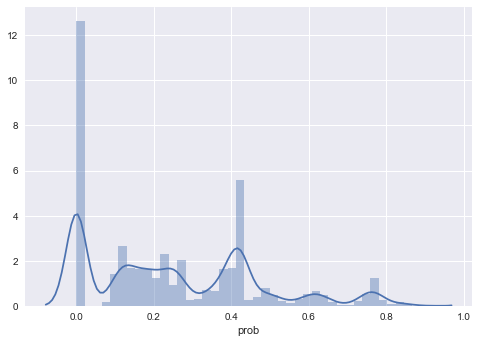

In [116]:
sns.distplot(log['prob'])

In [117]:
len(log[log['prob']>=0.8])

387

In [118]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55716 entries, 0 to 55715
Data columns (total 9 columns):
id      55716 non-null int64
prob    55716 non-null float32
A       55716 non-null int64
B       55716 non-null int64
C       55716 non-null int64
D       55716 non-null int64
E       55716 non-null int64
F       55716 non-null int64
G       55716 non-null int64
dtypes: float32(1), int64(8)
memory usage: 3.6 MB


### 8.2 Improve BaseLine

#### State Preference

In [143]:
pur=df2_all.take(ind,axis=0)
change1=pur[(pur['state']=='GA') & (pur['C']==1)]['customer_ID'].values

In [144]:
for i in change1:
    result.loc[result['id']==i,'C']=2.0

In [145]:
change2=pur[(pur['state']=='GA') & (pur['D']==2)]['customer_ID'].values

In [146]:
for i in change2:
    result.loc[result['id']==i,'D']=2.0

#### Individual G for Unstable Customer

In [123]:
X_train,y_train = train.drop(columns=['G','target']), train['G']

In [124]:
X_train=scaler.fit_transform(X_train)
test=scaler.transform(test)
xgc.fit(X_train,y_train)
predictedG=xgc.predict(test)

In [125]:
result['predict']=predictedG

In [126]:
for i in range(len(result)):
    if result.ix[i,'prob']>=0.8:
        result.ix[i,'G']=result.ix[i,predict]

In [127]:
submission=pd.DataFrame()
submission['customer_ID']=result['id']

In [150]:
for i in ['A','B','C','D','E','F','G']:
    result[i]=result[i].astype(int)

In [152]:
submission['plan'] = result['A'].astype(str)+result['B'].astype(str)+result['C'].astype(str)+result['D'].astype(str)+\
result['E'].astype(str)+result['F'].astype(str)+result['G'].astype(str)

In [154]:
submission.to_csv('submission.csv',index=False)

In [153]:
submission.head()

,customer_ID,plan
0,10000001,2113132
1,10000002,2023122
2,10000003,1021022
3,10000004,2011123
4,10000006,0011001


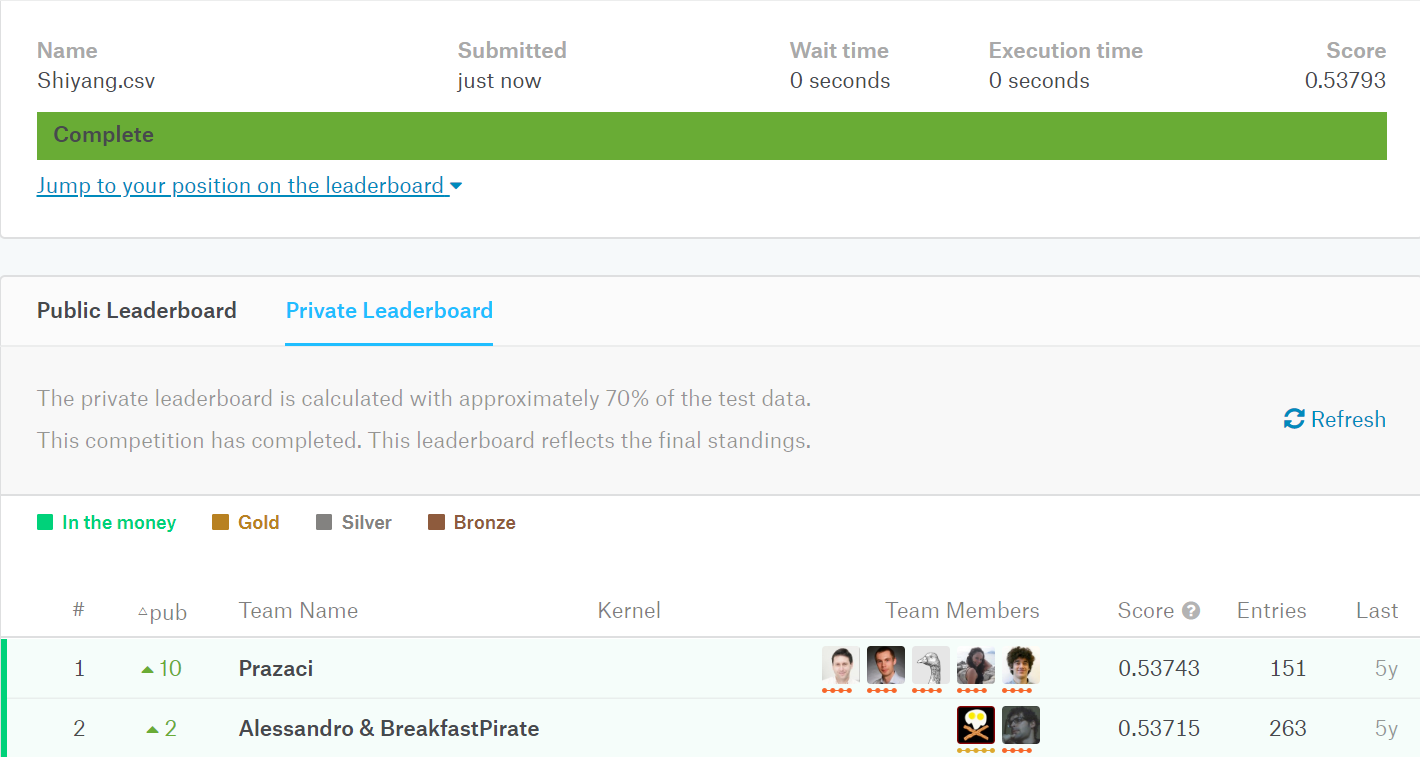

In [155]:
Image.open('score.png')